<a href="https://colab.research.google.com/github/imabari/ImabariScraping/blob/master/%E6%B2%96%E7%B8%84%E5%B8%82%E5%A0%B4%E6%9C%88%E5%A0%B1%E4%BD%8D%E7%BD%AE%E8%AA%BF%E6%95%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pdfplumber

     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 5.6MB 5.6MB/s 
     |████████████████████████████████| 143kB 42.6MB/s 
     |████████████████████████████████| 1.9MB 42.8MB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.5.26-cp36-none-any.whl size=31747 sha256=78bf25e4aea9f2e070a8cb84969c826348c540ab9734d22358d0941ebf802195
  Stored in directory: /root/.cache/pip/wheels/5a/4a/09/8f7b594a0d7ed1ca5fe27078a6a96e7439167a502074d87d1b
Successfully built pdfplumber


In [2]:
import pathlib

In [3]:
import pandas as pd
import pdfplumber
import requests
from bs4 import BeautifulSoup

In [4]:
def fetch_file(url, dir="."):

    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [5]:
def snap_adjustment(s, limit=5):

    count = s.value_counts().sort_index()

    index = 0
    value = 0

    for i, v in count.items():

        if (i - index) < limit:

            if v > value:
                s = s.replace(index, i)
                index = i
                value = v

            else:
                s = s.replace(i, index)

        else:
            index = i
            value = v

    return s

In [6]:
url = "https://www.pref.okinawa.jp/site/norin/oroshiuri/documents/documents/geppou3104.pdf"

In [7]:
p = fetch_file(url)

In [8]:
with pdfplumber.open(p) as pdf:

    dfs = []

    # ページ範囲指定（0スタート）
    for page in pdf.pages[32:35]:

        crop = page.within_bbox((0, 105, page.width, 800))

        df_tmp = (
            pd.DataFrame(crop.extract_words(keep_blank_chars=True))
            .astype({"x0": float, "x1": float, "top": float, "bottom": float})
            .sort_values(["top", "x0"])
        )

        df_tmp["top"] = snap_adjustment(df_tmp["top"])
        df_tmp["page"] = page.page_number

        dfs.append(df_tmp)

In [9]:
df = pd.concat(dfs)

In [10]:
df

,text,x0,x1,top,bottom,upright,direction,page
0,品 目,90.84,128.243,111.14,120.50,True,1,33
1,県 内,156.26,187.448,111.14,120.50,True,1,33
2,単価,208.10,226.820,111.14,120.50,True,1,33
3,県 外,249.41,280.598,111.14,120.50,True,1,33
4,単価,300.89,319.610,111.14,120.50,True,1,33
...,...,...,...,...,...,...,...,...
176,"1,728",266.93,287.550,625.18,634.54,True,1,35
177,216,308.81,322.850,625.18,634.54,True,1,35
178,"1,728",436.42,457.040,625.18,634.54,True,1,35
179,216,474.46,488.500,625.18,634.54,True,1,35


In [11]:
# テキスト処理
df["text"] = df["text"].str.replace("　", "").str.replace(",", "")

In [12]:
df["center"] = df.loc[:, ["x0", "x1"]].median(axis=1)

# 位置調整

snap_adjustmentのlimitで結合範囲を指定

## 左基準

In [13]:
df["x0"] = snap_adjustment(df["x0"])        

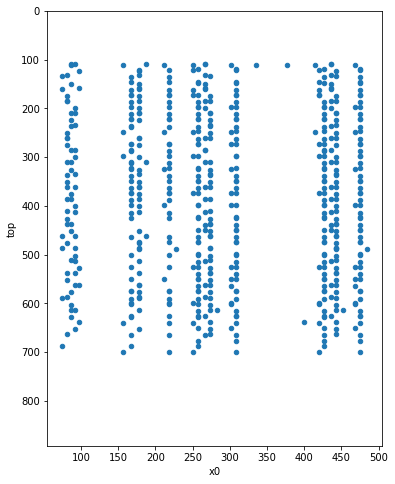

In [14]:
df.plot.scatter(x="x0", y="top", ylim=(892, 0), figsize=(6, 8))

## 中央基準

In [15]:
df["center"] = snap_adjustment(df["center"], 25)

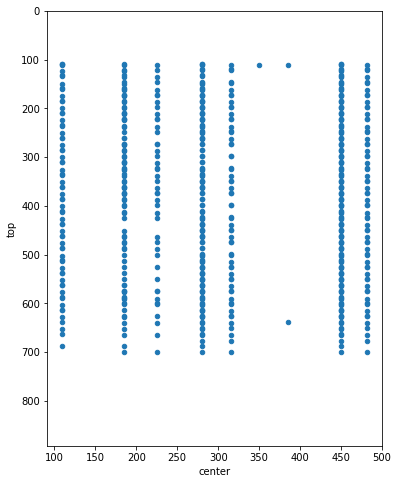

In [16]:
df.plot.scatter(x="center", y="top", ylim=(892, 0), figsize=(6, 8))

## 右基準

In [17]:
df["x1"] = snap_adjustment(df["x1"])

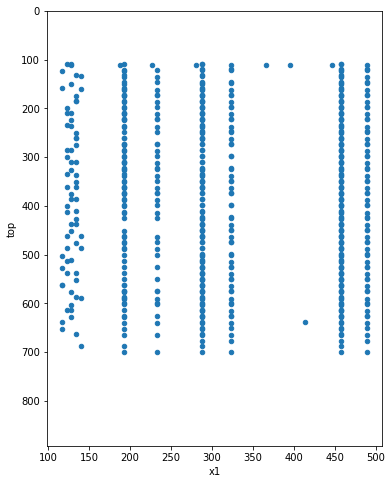

In [18]:
df.plot.scatter(x="x1", y="top", ylim=(892, 0), figsize=(6, 8))

In [19]:
table = (
    df.pivot_table(
        index=["page", "top"],
        columns="center",   # 基準を指定："x0", "x1", "center"
        values="text",
        aggfunc=lambda x: "".join(str(v) for v in x),
    )
).values

df1 = pd.DataFrame(table).dropna(thresh=2).dropna(how="all", axis=1)

In [20]:
df1

,0,1,2,3,4,5,6,7,8
0,品目,県内,単価,県外,単価,外国,単価,総計,単価
1,キク,78,NaN,NaN,NaN,NaN,NaN,78,NaN
2,NaN,12895,165,NaN,NaN,NaN,NaN,12895,165
3,ベゴニア類,34,NaN,4218,NaN,NaN,NaN,4252,NaN
4,NaN,6426,189,1306246,310,NaN,NaN,1312672,309
...,...,...,...,...,...,...,...,...,...
130,NaN,12960,589,48600,386,NaN,NaN,61560,416
131,ハイドランジア,18,NaN,8756,NaN,NaN,NaN,8774,NaN
132,NaN,11286,627,8862941,1012,NaN,NaN,8874227,1011
133,プリムラ類,NaN,NaN,8,NaN,NaN,NaN,8,NaN


In [21]:
df1.to_csv("test.csv", encoding="utf_8_sig")

# 前処理

In [22]:
df2 = df1[df1[0] != "品目"].copy()

In [23]:
df2

,0,1,2,3,4,5,6,7,8
1,キク,78,NaN,NaN,NaN,NaN,NaN,78,NaN
2,NaN,12895,165,NaN,NaN,NaN,NaN,12895,165
3,ベゴニア類,34,NaN,4218,NaN,NaN,NaN,4252,NaN
4,NaN,6426,189,1306246,310,NaN,NaN,1312672,309
5,インパチェンス,804,NaN,70,NaN,NaN,NaN,874,NaN
...,...,...,...,...,...,...,...,...,...
130,NaN,12960,589,48600,386,NaN,NaN,61560,416
131,ハイドランジア,18,NaN,8756,NaN,NaN,NaN,8774,NaN
132,NaN,11286,627,8862941,1012,NaN,NaN,8874227,1011
133,プリムラ類,NaN,NaN,8,NaN,NaN,NaN,8,NaN


In [24]:
df2[0] = df2[0].fillna(method="ffill")

In [25]:
df_even = (
    df2[::2]
    .set_axis(
        [
            "品名",
            "県内_数量",
            "県内_単価",
            "県外_数量",
            "県外_単価",
            "外国_数量",
            "外国_単価",
            "総計_数量",
            "総計_単価",
        ],
        axis=1,
    )
    .dropna(how="all", axis=1)
)
df_even

,品名,県内_数量,県外_数量,総計_数量
1,キク,78,NaN,78
3,ベゴニア類,34,4218,4252
5,インパチェンス,804,70,874
7,ガーベラ,96,2432,2528
9,ゼラニウム,416,126,542
...,...,...,...,...
125,クレマチス,NaN,252,252
127,デンドロビウム,NaN,603,603
129,ツツジ,22,126,148
131,ハイドランジア,18,8756,8774


In [26]:
df_odd = (
    df2[1::2]
    .set_axis(
        [
            "品名",
            "県内_金額",
            "県内_単価",
            "県外_金額",
            "県外_単価",
            "外国_金額",
            "外国_単価",
            "総計_金額",
            "総計_単価",
        ],
        axis=1,
    )
    .dropna(how="all", axis=1)
)
df_odd

,品名,県内_金額,県内_単価,県外_金額,県外_単価,総計_金額,総計_単価
2,キク,12895,165,NaN,NaN,12895,165
4,ベゴニア類,6426,189,1306246,310,1312672,309
6,インパチェンス,100607,125,19440,278,120047,137
8,ガーベラ,8294,86,543593,224,551887,218
10,ゼラニウム,55037,132,57240,454,112277,207
...,...,...,...,...,...,...,...
126,クレマチス,NaN,NaN,282552,1121,282552,1121
128,デンドロビウム,NaN,NaN,499111,828,499111,828
130,ツツジ,12960,589,48600,386,61560,416
132,ハイドランジア,11286,627,8862941,1012,8874227,1011


In [27]:
df3 = (
    pd.merge(df_even, df_odd, on="品名")
    .set_index("品名")
    .reindex(
        columns=[
            "県内_数量",
            "県内_単価",
            "県内_金額",
            "県外_数量",
            "県外_単価",
            "県外_金額",
            "外国_数量",
            "外国_単価",
            "外国_金額",
            "総計_数量",
            "総計_単価",
            "総計_金額",
        ]
    )
)

In [28]:
df3

,県内_数量,県内_単価,県内_金額,県外_数量,県外_単価,県外_金額,外国_数量,外国_単価,外国_金額,総計_数量,総計_単価,総計_金額
品名,,,,,,,,,,,,
キク,78,165,12895,NaN,NaN,NaN,NaN,NaN,NaN,78,165,12895
ベゴニア類,34,189,6426,4218,310,1306246,NaN,NaN,NaN,4252,309,1312672
インパチェンス,804,125,100607,70,278,19440,NaN,NaN,NaN,874,137,120047
ガーベラ,96,86,8294,2432,224,543593,NaN,NaN,NaN,2528,218,551887
ゼラニウム,416,132,55037,126,454,57240,NaN,NaN,NaN,542,207,112277
...,...,...,...,...,...,...,...,...,...,...,...,...
クレマチス,NaN,NaN,NaN,252,1121,282552,NaN,NaN,NaN,252,1121,282552
デンドロビウム,NaN,NaN,NaN,603,828,499111,NaN,NaN,NaN,603,828,499111
ツツジ,22,589,12960,126,386,48600,NaN,NaN,NaN,148,416,61560


In [29]:
df3.to_csv("okinawa.csv", encoding="utf_8_sig")

In [30]:
from google.colab import files

files.download("okinawa.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>